# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random

# Visualize Data

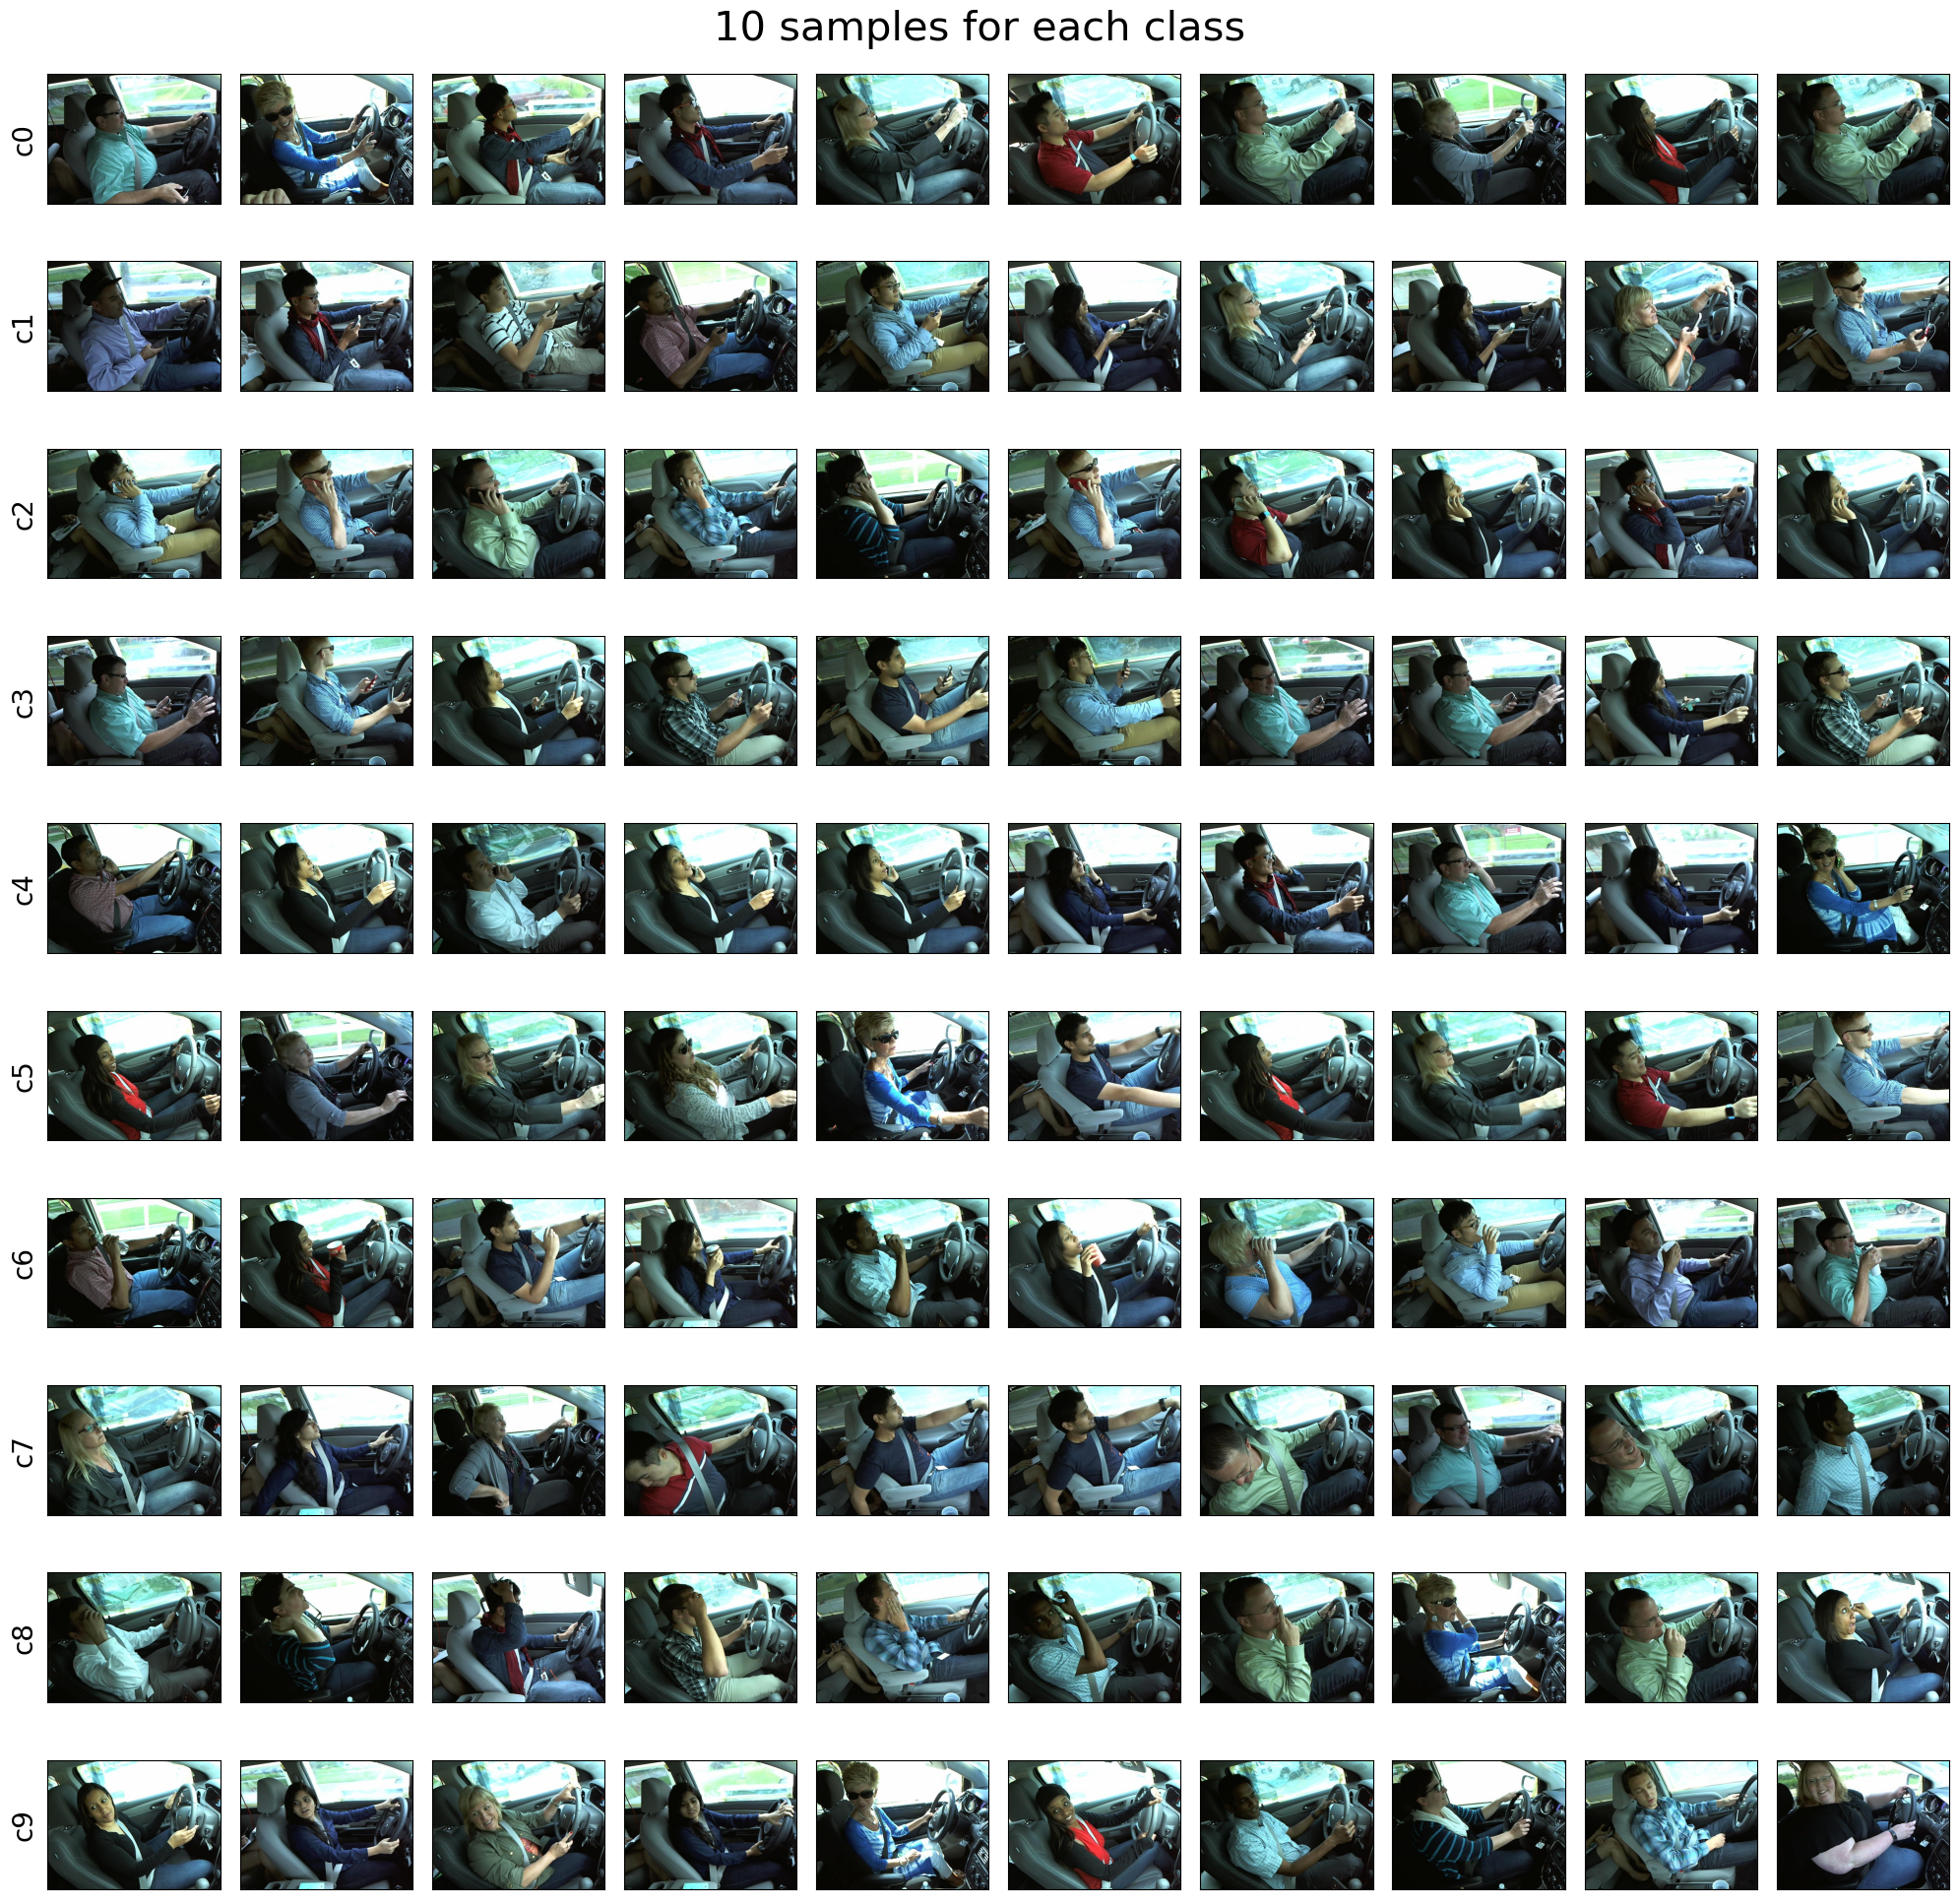

In [2]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

train_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/'
labels = [f'c{i}' for i in range(10)]

for i, label in enumerate(labels):
  sample = os.listdir(train_dir+label)[:10]
  for j, img in enumerate(sample):
    img_path = train_dir+label+'/'+img
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i, j].imshow(img)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

    if j == 0 :
      ax[i, j].set_ylabel(label, fontsize=20)

fig.suptitle('10 samples for each class', fontsize=30)
plt.tight_layout()        

# Model

In [3]:
evaluation_df = pd.DataFrame()
models_dict = {}

## ETL Pipeline for Baseline models

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=.2
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='validation'
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## Baseline Dense layers model

In [5]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Flatten(input_shape=(256, 256, 3)))
model.add(layers.Dense(512, activation='relu', name='layer_1'))
model.add(layers.Dense(256, activation='relu', name='layer_2'))
model.add(layers.Dense(128, activation='relu', name='layer_3'))
model.add(layers.Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 layer_1 (Dense)             (None, 512)               100663808 
                                                                 
 layer_2 (Dense)             (None, 256)               131328    
                                                                 
 layer_3 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 100,829,322
Trainable params: 100,829,322
Non-trainable params: 0
_________________________________________________________________


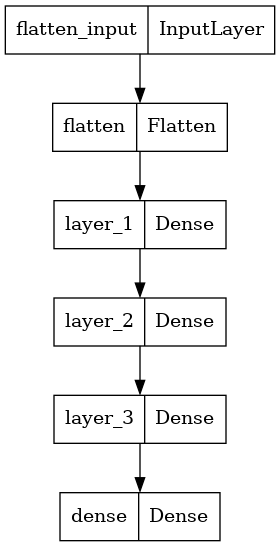

In [7]:
from keras.utils import plot_model

plot_model(model)

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
561/561 [==============================] - 280s 487ms/step - loss: 5.8791 - accuracy: 0.5942 - val_loss: 0.3559 - val_accuracy: 0.8915
Epoch 2/10
561/561 [==============================] - 147s 263ms/step - loss: 0.3360 - accuracy: 0.8974 - val_loss: 0.2936 - val_accuracy: 0.8980
Epoch 3/10
561/561 [==============================] - 160s 284ms/step - loss: 0.2915 - accuracy: 0.9076 - val_loss: 0.4916 - val_accuracy: 0.8578
Epoch 4/10
561/561 [==============================] - 161s 287ms/step - loss: 0.1810 - accuracy: 0.9440 - val_loss: 0.1500 - val_accuracy: 0.9489
Epoch 5/10
561/561 [==============================] - 158s 282ms/step - loss: 0.2401 - accuracy: 0.9270 - val_loss: 1.0030 - val_accuracy: 0.7228
Epoch 6/10
561/561 [==============================] - 150s 268ms/step - loss: 0.2307 - accuracy: 0.9296 - val_loss: 0.3011 - val_accuracy: 0.9127
Epoch 7/10
561/561 [==============================] - 152s 271ms/step - loss: 0.2099 - accuracy: 0.9364 - val_loss: 0.2100 -

##### Train VS Validation

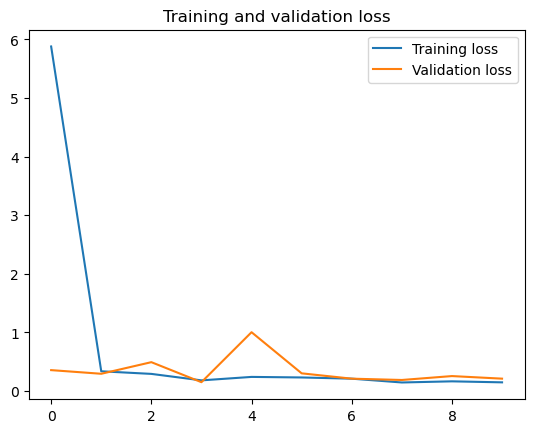

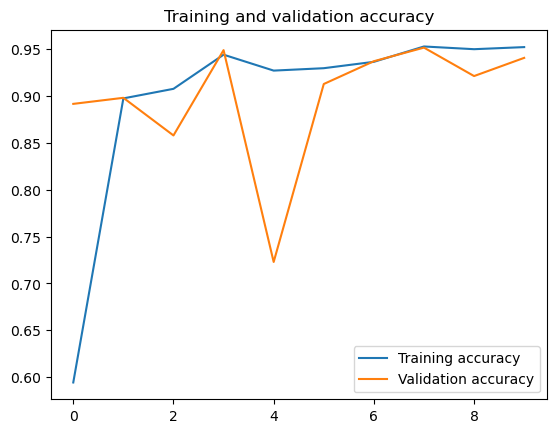

In [10]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [11]:
model.save('/kaggle/working/Distracted_Driver_Detection_baseline_dense.h5')

##### Save Performace

In [12]:
model_name = 'Dense Baseline'
models_dict[model_name] = '/kaggle/working/Distracted_Driver_Detection_baseline_dense.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

141/141 [==============================] - 29s 203ms/step - loss: 0.2103 - accuracy: 0.9406


## Baseline CNN model

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),  activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),  activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))#, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)     

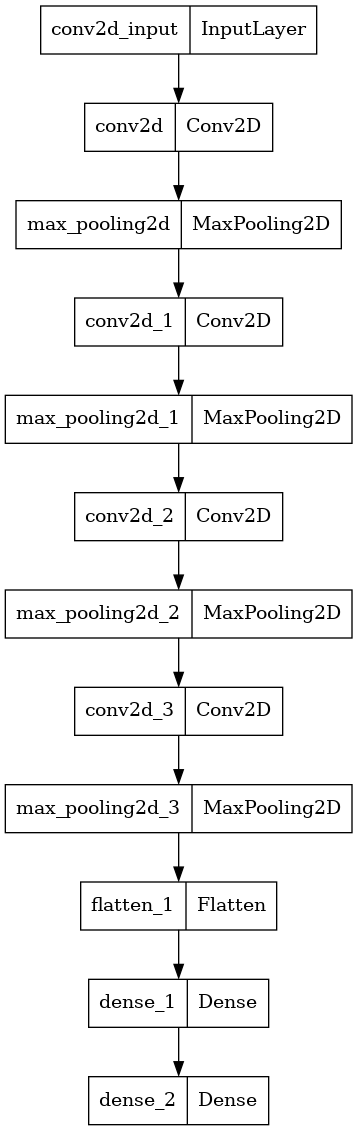

In [15]:
from keras.utils import plot_model

plot_model(model)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
561/561 [==============================] - 172s 288ms/step - loss: 0.4983 - accuracy: 0.8387 - val_loss: 0.1061 - val_accuracy: 0.9712
Epoch 2/10
561/561 [==============================] - 169s 301ms/step - loss: 0.0506 - accuracy: 0.9862 - val_loss: 0.0516 - val_accuracy: 0.9868
Epoch 3/10
561/561 [==============================] - 159s 282ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.0566 - val_accuracy: 0.9875
Epoch 4/10
561/561 [==============================] - 161s 287ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0396 - val_accuracy: 0.9929
Epoch 5/10
561/561 [==============================] - 161s 286ms/step - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.0318 - val_accuracy: 0.9913
Epoch 6/10
561/561 [==============================] - 156s 278ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0707 - val_accuracy: 0.9833
Epoch 7/10
561/561 [==============================] - 173s 308ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0542 -

##### Train VS Validation

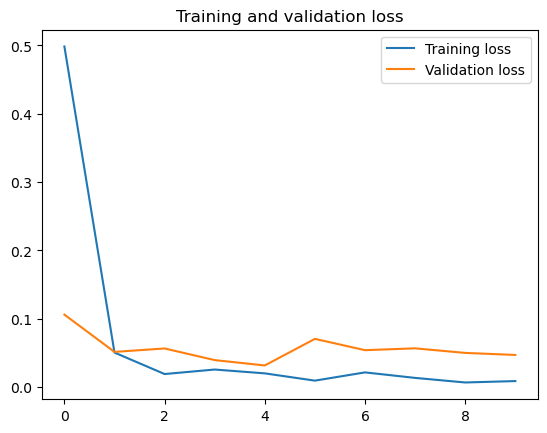

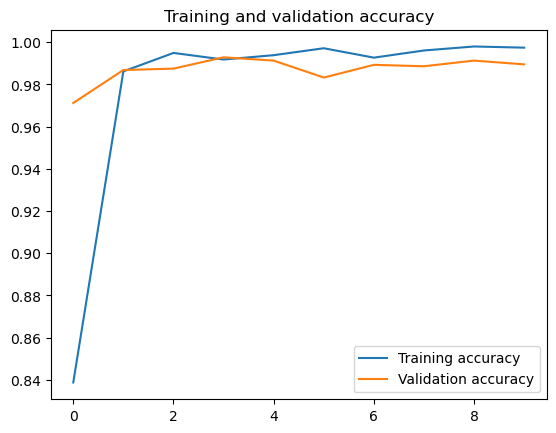

In [18]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [19]:
model.save('/kaggle/working/MyDrive/Distracted_Driver_Detection_baseline_cnn.h5')

##### Save Performace

In [20]:
model_name = 'CNN Baseline'
models_dict[model_name] = '/kaggle/working/Distracted_Driver_Detection_baseline_cnn.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

141/141 [==============================] - 31s 220ms/step - loss: 0.0472 - accuracy: 0.9895


## ETL Pipeline for data augmentation

In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.05,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05, 
                                   fill_mode='nearest',
                                   validation_split=.2)

# validation should not be augmented !
validation_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=.2)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## CNN with Data augmentation

In [22]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),  activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),  activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))#, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 128)     

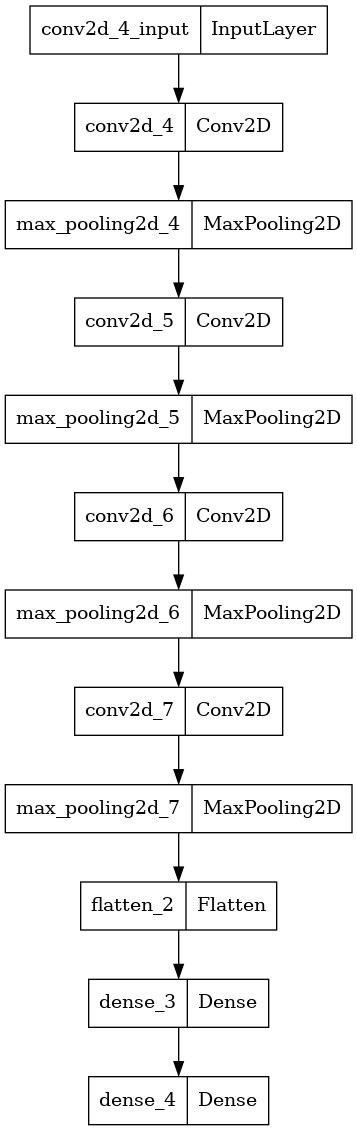

In [24]:
from keras.utils import plot_model

plot_model(model)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
561/561 [==============================] - 389s 689ms/step - loss: 0.9360 - accuracy: 0.6759 - val_loss: 0.1870 - val_accuracy: 0.9458
Epoch 2/10
561/561 [==============================] - 443s 788ms/step - loss: 0.1960 - accuracy: 0.9410 - val_loss: 0.0688 - val_accuracy: 0.9808
Epoch 3/10
561/561 [==============================] - 399s 711ms/step - loss: 0.1165 - accuracy: 0.9637 - val_loss: 0.0659 - val_accuracy: 0.9821
Epoch 4/10
561/561 [==============================] - 387s 690ms/step - loss: 0.0839 - accuracy: 0.9736 - val_loss: 0.0342 - val_accuracy: 0.9904
Epoch 5/10
561/561 [==============================] - 380s 676ms/step - loss: 0.0666 - accuracy: 0.9794 - val_loss: 0.0497 - val_accuracy: 0.9879
Epoch 6/10
561/561 [==============================] - 407s 725ms/step - loss: 0.0571 - accuracy: 0.9812 - val_loss: 0.0395 - val_accuracy: 0.9893
Epoch 7/10
561/561 [==============================] - 399s 711ms/step - loss: 0.0481 - accuracy: 0.9841 - val_loss: 0.0324 -

##### Train VS Validation

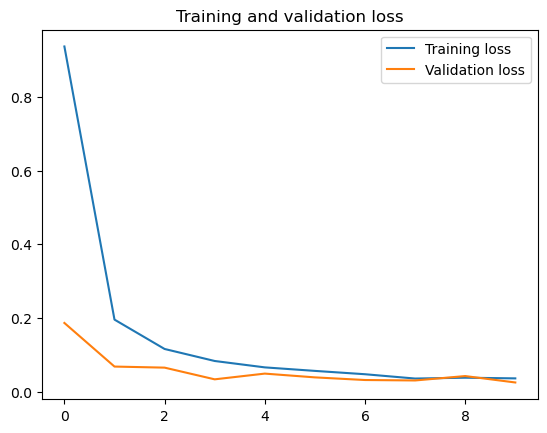

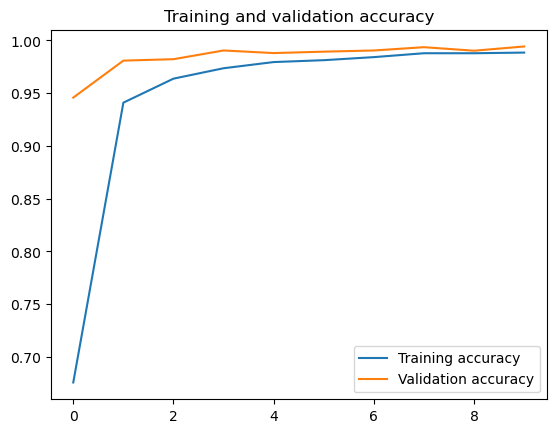

In [27]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [28]:
model.save('/kaggle/working/Distracted_Driver_Detection_cnn_data_augmentation.h5')

##### Save Performace

In [29]:
model_name = 'CNN & Data Augmentation'
models_dict[model_name] = '/kaggle/working/Distracted_Driver_Detection_cnn_data_augmentation.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

141/141 [==============================] - 32s 226ms/step - loss: 0.0257 - accuracy: 0.9942


## ETL Pipeline for Transfer Learning

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

train_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

train_datagen = ImageDataGenerator(
                                   preprocessing_function=preprocess_input,
                                   zoom_range=0.05,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05, 
                                   fill_mode='nearest',
                                   validation_split=.2)

# validation should not be augmented !
validation_datagen = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,
                                        validation_split=.2)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size = 32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## Transfer Learning

In [31]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape=(256, 256, 3))

conv_base.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [33]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               8388864   
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 23,106,122
Trainable params: 8,391,434
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      )

Epoch 1/10
561/561 [==============================] - 422s 737ms/step - loss: 2.1974 - accuracy: 0.7747 - val_loss: 0.4718 - val_accuracy: 0.9087
Epoch 2/10
561/561 [==============================] - 421s 751ms/step - loss: 0.2418 - accuracy: 0.9393 - val_loss: 0.1273 - val_accuracy: 0.9714
Epoch 3/10
561/561 [==============================] - 412s 734ms/step - loss: 0.1656 - accuracy: 0.9609 - val_loss: 0.1356 - val_accuracy: 0.9661
Epoch 4/10
561/561 [==============================] - 412s 735ms/step - loss: 0.1490 - accuracy: 0.9664 - val_loss: 0.1712 - val_accuracy: 0.9739
Epoch 5/10
561/561 [==============================] - 408s 727ms/step - loss: 0.1183 - accuracy: 0.9755 - val_loss: 0.0942 - val_accuracy: 0.9830
Epoch 6/10
561/561 [==============================] - 407s 725ms/step - loss: 0.1086 - accuracy: 0.9772 - val_loss: 0.0850 - val_accuracy: 0.9824
Epoch 7/10
561/561 [==============================] - 407s 724ms/step - loss: 0.0960 - accuracy: 0.9814 - val_loss: 0.3499 -

##### Train VS Validation

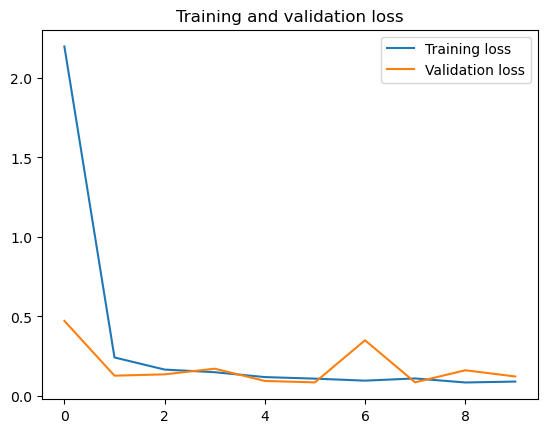

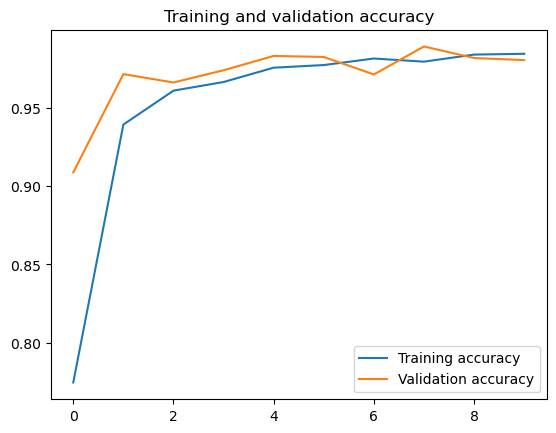

In [37]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [38]:
model.save('/kaggle/working/Distracted_Driver_Detection_transfer_learning.h5')

##### Save Performace

In [39]:
model_name = 'Transfer-Learning'
models_dict[model_name] = '/kaggle/working/Distracted_Driver_Detection_transfer_learning.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

141/141 [==============================] - 41s 288ms/step - loss: 0.1221 - accuracy: 0.9804


## Fine-tuning

In [40]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape=(256, 256, 3))

conv_base.trainable = False

In [41]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [42]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               8388864   
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 23,106,122
Trainable params: 8,391,434
Non-trainable params: 14,714,688
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator)

Epoch 1/5
561/561 [==============================] - 418s 742ms/step - loss: 2.9429 - accuracy: 0.7393 - val_loss: 0.3231 - val_accuracy: 0.9141
Epoch 2/5
561/561 [==============================] - 421s 750ms/step - loss: 0.2753 - accuracy: 0.9341 - val_loss: 0.1364 - val_accuracy: 0.9710
Epoch 3/5
561/561 [==============================] - 415s 738ms/step - loss: 0.1517 - accuracy: 0.9643 - val_loss: 0.1901 - val_accuracy: 0.9601
Epoch 4/5
561/561 [==============================] - 415s 738ms/step - loss: 0.1268 - accuracy: 0.9683 - val_loss: 0.1093 - val_accuracy: 0.9804
Epoch 5/5
561/561 [==============================] - 410s 730ms/step - loss: 0.0907 - accuracy: 0.9801 - val_loss: 0.0465 - val_accuracy: 0.9886


In [46]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
      break
    else:
        layer.trainable = False

In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               8388864   
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 23,106,122
Trainable params: 15,470,858
Non-trainable params: 7,635,264
_________________________________________________________________


In [48]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
561/561 [==============================] - 416s 742ms/step - loss: 0.0887 - accuracy: 0.9784 - val_loss: 0.0710 - val_accuracy: 0.9855
Epoch 2/10
561/561 [==============================] - 422s 752ms/step - loss: 0.1025 - accuracy: 0.9798 - val_loss: 0.0976 - val_accuracy: 0.9808
Epoch 3/10
561/561 [==============================] - 408s 727ms/step - loss: 0.0690 - accuracy: 0.9850 - val_loss: 0.0628 - val_accuracy: 0.9888
Epoch 4/10
561/561 [==============================] - 405s 721ms/step - loss: 0.0972 - accuracy: 0.9816 - val_loss: 0.0806 - val_accuracy: 0.9850
Epoch 5/10
561/561 [==============================] - 407s 725ms/step - loss: 0.0682 - accuracy: 0.9855 - val_loss: 0.1569 - val_accuracy: 0.9772
Epoch 6/10
561/561 [==============================] - 410s 730ms/step - loss: 0.0726 - accuracy: 0.9858 - val_loss: 0.0744 - val_accuracy: 0.9871
Epoch 7/10
561/561 [==============================] - 404s 719ms/step - loss: 0.0625 - accuracy: 0.9881 - val_loss: 0.0655 -

##### Train VS Validation

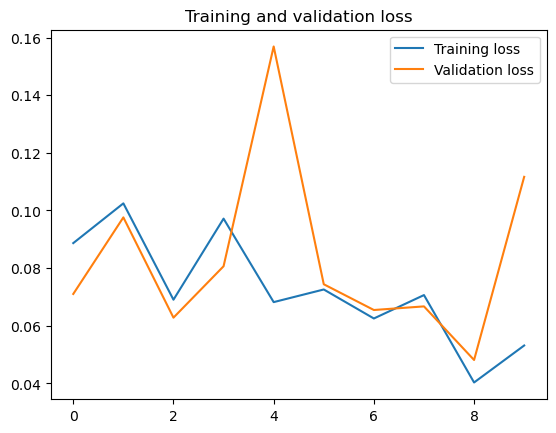

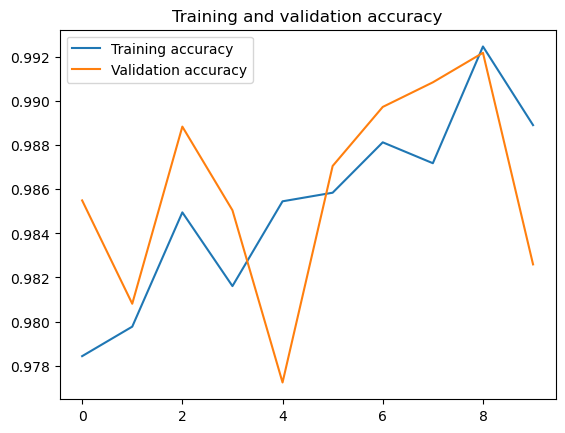

In [49]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##### Save model

In [50]:
model.save('/kaggle/working/Distracted_Driver_Detection_fine_tuning.h5')

##### Save Performace

In [51]:
model_name = 'Fine-Tuning'
models_dict[model_name] = '/kaggle/working/Distracted_Driver_Detection_fine_tuning.h5'

train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(validation_generator)

evaluation = pd.DataFrame({
                          'Model' : [model_name],
                          'Train' : [train_accuracy],
                          'Validation' : [validation_accuracy]
                        })

evaluation_df = pd.concat([evaluation_df, evaluation], ignore_index=True)

141/141 [==============================] - 38s 268ms/step - loss: 0.1117 - accuracy: 0.9826


# Evaluation

In [52]:
evaluation_df

Model     Train  Validation
0           Dense Baseline  0.949618    0.940638
1             CNN Baseline  0.997213    0.989511
2  CNN & Data Augmentation  0.991975    0.994198
3        Transfer-Learning  0.984618    0.980362
4              Fine-Tuning  0.984172    0.982593

In [53]:
from keras.models import load_model
# Get best model according to validation score
best_model = evaluation_df[evaluation_df['Validation'] == evaluation_df['Validation'].max()]['Model'].values[0]
model = load_model(models_dict[best_model])

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 128)     

# Submission File Generation

### Utility Functions

In [55]:
def preprocess(images, rescale=1./255):
  """
  Takes numpy array.
    Args:
      rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
        is applied, otherwise we multiply the data by the value provided
        (after applying all other transformations).

  Returns:
      A numpy array
  """

  # apply the pre-processing that utilized during training.
  if rescale and rescale != 0 :
    images = images*rescale
  
  return images 

In [56]:
# def test_flow_from_directory(directory, batch_size=32, target_size=(256, 256), preprocess_input=None, shuffle=False):
#   """
#   Takes the path to a directory & generates batches.
#     Args:
#       directory: string, path to the target directory. 
#       batch_size: Size of the batches of data (default: 32).
#       target_size: Tuple of integers `(height, width)`, The dimensions to which all images found will be resized,
#         defaults to `None`.
#       rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
#         is applied, otherwise we multiply the data by the value provided
#         (after applying all other transformations).
#       shuffle: Whether to shuffle the data (default: True).
#       preprocess_input: the pre-processing function that utilized during training.

#   Returns:
#       A numpy array containing a batch of images with shape
#       `(batch_size, *target_size, channels)`
#   """


#   file_names = os.listdir(directory)
#   if shuffle:
#     random.shuffle(file_names)

#   for i in range(len(file_names)+1//batch_size):

#     # get batch 
#     start = i * batch_size
#     end = (i+1) * batch_size
#     batch_file_names = file_names[start:end]
#     batch_file_names_path = list(map(lambda name: directory+'/'+name, batch_file_names))

#     # read image in BGR format
#     images = np.array(list(map(lambda file: cv2.imread(file), batch_file_names_path)))
    
#     # convert image to RGB format
#     images = np.array(list(map(lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB), images)))

#     # pre-processing 
#     if preprocess_input:
#       images = np.array(list(map(lambda x: cv2.resize(x, target_size), images)))
#       images = preprocess_input(images)
    
#     yield batch_file_names, images

### Inference using manual test generator (test_flow_from_directory)

In [57]:
# from keras.applications.imagenet_utils import preprocess_input

# # Get the pre-processing function that utilized during training.
# if best_model in('Fine-Tuning', 'Transfer-Learning'):
#     preprocess_function = preprocess_input
# else:
#     preprocess_function = preprocess

In [58]:
# submission_df = pd.DataFrame()

# test_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'

# for batch_file_names, images in (test_flow_from_directory(test_dir,
#                                                           preprocess_input=preprocess_function)):
#   # model predictions
#   predictions = model.predict(images, verbose=0)
  
#   # concat image file name with its prediction
#   arr = np.array([[batch_file_names[i]] + predictions.tolist()[i] for i in range(len(predictions))])
  
#   # appned image file name with its prediction as a record in dataframe
#   submission_df = pd.concat((submission_df, pd.DataFrame(arr)))

get columns names from sample_submission csv and assign it to our dataframe

In [59]:
# sample_submission_df = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv')

# submission_df.columns = sample_submission_df.columns
# submission_df.columns

In [60]:
# submission_df.head()

In [61]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)

### Inference using built-in test_generator

In [62]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

# Get the pre-processing function that utilized during training.
if best_model in('Fine-Tuning', 'Transfer-Learning'):
    preprocess_function = preprocess_input
else:
    preprocess_function = preprocess

test_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),
    batch_size = 32,
    classes=['test'],
    class_mode=None,
    shuffle=False
)

Found 79726 images belonging to 1 classes.


In [63]:
file_names = sorted(os.listdir(test_dir+'test'))
len(file_names)

79726

In [64]:
predictions = model.predict(test_generator, verbose=0)
predictions.shape

(79726, 10)

In [65]:
submission_df = pd.DataFrame()

# concat image file name with its prediction
arr = np.array([[file_names[i]] + predictions.tolist()[i] for i in range(len(predictions))])

# appned image file name with its prediction as a record in dataframe
submission_df = pd.concat((submission_df, pd.DataFrame(arr)))

In [66]:
sample_submission_df = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv')
submission_df.columns = sample_submission_df.columns
submission_df.columns

Index(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], dtype='object')

In [67]:
submission_df.head()

img                      c0                      c1  \
0       img_1.jpg   9.000645367907012e-11   4.703863055727217e-18   
1      img_10.jpg  1.2803248045090143e-12   3.781176252366878e-17   
2     img_100.jpg      0.4064369797706604     0.07291901856660843   
3    img_1000.jpg   0.0004653582291211933  0.00022943380463402718   
4  img_100000.jpg  4.5731545128546713e-07  1.3595739117855388e-11   

                       c2                      c3                      c4  \
0   7.609057562632179e-14   4.122546488211087e-12   6.729857227050218e-10   
1  1.2104427703218956e-12  1.6796056868462542e-14    5.89174637354549e-14   
2    0.000780609727371484     0.06963736563920975     0.04136999323964119   
3      0.1573636829853058   0.0003803159634117037  0.00015933861141093075   
4  2.0833620939519903e-10     0.42373785376548767      0.5237476229667664   

                       c5                     c6                      c7  \
0                     1.0  7.852473994662563e-16    5.80936340699445e-13   
1                     1.0  6.930383350534086e-11  5.9318615797110397e-08   
2  0.00042078839032910764   0.013628422282636166    6.84585347698885e-06   
3   5.402075839811005e-05     0.8257696032524109   0.0007039527408778667   
4      0.0523279532790184  6.375799888047595e-10  2.7115603599275895e-12   

                       c8                      c9  
0   1.978891226231405e-12   2.781606278645654e-09  
1   7.253624922931579e-10  1.6904432020847793e-10  
2   7.594154158141464e-05     0.39472392201423645  
3    0.014846405945718288   2.787000084936153e-05  
4  0.00016054041043389589  2.5555669708410278e-05

In [68]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)